# All imports

In [45]:
from typing import Type, Any, Callable, Union, List, Optional

import torch.nn as nn
from torch import Tensor

from collections import namedtuple

import cv2
import numpy as np
import torch
import argparse
from collections import namedtuple
import numpy as np
import torch
from path import Path
import pickle
import xml.etree.ElementTree as ET

import cv2
from path import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F


# utils.py

In [46]:


def compute_scale_down(input_size, output_size):
    """вычисляем масштаб сжатия нейронной сети."""
    return output_size[0] / input_size[0]


def prob_true(p):
    """True p"""
    return np.random.random() < p

# aabb.py

In [47]:
class AABB:
    '''
    Данный класс отвечает за boundingbox из opencv-python
    За рамки вокруг слов
    '''


    def __init__(self, xmin, xmax, ymin, ymax):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

    def scale(self, fx, fy):
        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = fx * new.xmin
        new.xmax = fx * new.xmax
        new.ymin = fy * new.ymin
        new.ymax = fy * new.ymax
        return new

    def scale_around_center(self, fx, fy):
        cx = (self.xmin + self.xmax) / 2
        cy = (self.ymin + self.ymax) / 2

        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = cx - fx * (cx - self.xmin)
        new.xmax = cx + fx * (self.xmax - cx)
        new.ymin = cy - fy * (cy - self.ymin)
        new.ymax = cy + fy * (self.ymax - cy)
        return new

    def translate(self, tx, ty):
        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = new.xmin + tx
        new.xmax = new.xmax + tx
        new.ymin = new.ymin + ty
        new.ymax = new.ymax + ty
        return new

    def as_type(self, t):
        '''
        :param t: тип к котором надо привести координаты рамок. сделана чтобы приводить к int, поскольку выделение слов
        и вырезание работает с цуелочисленными координатами
        :return:
        '''
        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = t(new.xmin)
        new.xmax = t(new.xmax)
        new.ymin = t(new.ymin)
        new.ymax = t(new.ymax)
        return new

    def enlarge_to_int_grid(self):
        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = np.floor(new.xmin)
        new.xmax = np.ceil(new.xmax)
        new.ymin = np.floor(new.ymin)
        new.ymax = np.ceil(new.ymax)
        return new

    def clip(self, clip_aabb):
        new = AABB(self.xmin, self.xmax, self.ymin, self.ymax)
        new.xmin = min(max(new.xmin, clip_aabb.xmin), clip_aabb.xmax)
        new.xmax = max(min(new.xmax, clip_aabb.xmax), clip_aabb.xmin)
        new.ymin = min(max(new.ymin, clip_aabb.ymin), clip_aabb.ymax)
        new.ymax = max(min(new.ymax, clip_aabb.ymax), clip_aabb.ymin)
        return new

    def area(self):
        '''
        Вычисляет площадь выделенной области(слова)
        :return:
        '''
        return (self.xmax - self.xmin) * (self.ymax - self.ymin)

    def __str__(self):
        return f'AABB(xmin={self.xmin},xmax={self.xmax},ymin={self.ymin},ymax={self.ymax})'

    def __repr__(self):
        return str(self)

# Dataloader.py

In [48]:
'''
DataLoader
сетка сама по себе не может съесть изображение, это не табличные данные и все изображения нельзя держать в памяти разом
DataLoader подгружает изображения поочередно подготовив их
'''



DataLoaderItem = namedtuple('DataLoaderItem', 'batch_imgs,batch_gt_maps,batch_aabbs')


class DataLoaderIAM:
    """DataLoader для IAM на котором изначально было обучение"""

    def __init__(self, dataset, batch_size, input_size, output_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size
        self.scale_down = compute_scale_down(input_size, output_size)
        self.shuffled_indices = np.arange(len(self.dataset))
        self.curr_idx = 0
        self.is_random = False

    def __getitem__(self, item):
        batch_imgs = []
        batch_gt_maps = []
        batch_aabbs = []
        for b in range(self.batch_size):
            if self.is_random:
                shuffled_idx = self.shuffled_indices[item * self.batch_size + b]
            else:
                shuffled_idx = item * self.batch_size + b

            img, aabbs = self.dataset[shuffled_idx]

            if self.is_random:
                # geometric data augmentation (image [0..255] and gt)
                if prob_true(0.75):
                    # random scale
                    fx = np.random.uniform(0.5, 1.5)
                    fy = np.random.uniform(0.5, 1.5)

                    # random position around center
                    txc = self.input_size[1] * (1 - fx) / 2
                    tyc = self.input_size[0] * (1 - fy) / 2
                    freedom_x = self.input_size[1] // 10
                    freedom_y = self.input_size[0] // 10
                    tx = txc + np.random.randint(-freedom_x, freedom_x)
                    ty = tyc + np.random.randint(-freedom_y, freedom_y)

                    # map image into target image
                    M = np.float32([[fx, 0, tx], [0, fy, ty]])
                    white_bg = np.ones(self.input_size, np.uint8) * 255
                    img = cv2.warpAffine(img, M, dsize=self.input_size[::-1], dst=white_bg,
                                         borderMode=cv2.BORDER_TRANSPARENT)

                    # apply the same transformations to gt, and clip/remove aabbs outside of target image
                    aabb_clip = AABB(0, img.shape[1], 0, img.shape[0])
                    aabbs = [aabb.scale(fx, fy).translate(tx, ty).clip(aabb_clip) for aabb in aabbs]
                    aabbs = [aabb for aabb in aabbs if aabb.area() > 0]

                # photometric data augmentation (image [-0.5..0.5] only)
                img = (img / 255 - 0.5)
                if prob_true(0.25):  # random distractors (lines)
                    num_lines = np.random.randint(1, 20)
                    for _ in range(num_lines):
                        rand_pt = lambda: (np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0]))
                        color = np.random.triangular(-0.5, 0, 0.5)
                        thickness = np.random.randint(1, 3)
                        cv2.line(img, rand_pt(), rand_pt(), color, thickness)
                if prob_true(0.75):  # random contrast
                    img = (img - img.min()) / (img.max() - img.min()) - 0.5  # stretch
                    img = img * np.random.triangular(0.1, 0.9, 1)  # reduce contrast
                if prob_true(0.25):  # random noise
                    img = img + np.random.uniform(-0.1, 0.1, size=img.shape)
                if prob_true(0.25):  # change thickness of text
                    img = cv2.erode(img, np.ones((3, 3)))
                if prob_true(0.25):  # change thickness of text
                    img = cv2.dilate(img, np.ones((3, 3)))
                if prob_true(0.25):  # invert image
                    img = 0.5 - img

            else:
                img = (img / 255 - 0.5)

            gt_map = encode(self.output_size, aabbs, self.scale_down)

            batch_imgs.append(img[None, ...].astype(np.float32))
            batch_gt_maps.append(gt_map)
            batch_aabbs.append(aabbs)

        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_gt_maps = np.stack(batch_gt_maps, axis=0)

        batch_imgs = torch.from_numpy(batch_imgs).to('cuda')
        batch_gt_maps = torch.from_numpy(batch_gt_maps.astype(np.float32)).to('cuda')

        return DataLoaderItem(batch_imgs, batch_gt_maps, batch_aabbs)

    def reset(self):
        self.curr_idx = 0

    def random(self, enable=True):
        np.random.shuffle(self.shuffled_indices)
        self.is_random = enable

    def __len__(self):
        return len(self.dataset) // self.batch_size


class DataLoaderImgFile:
    """DataLoader для директории"""

    def __init__(self, root_dir, input_size, device, max_side_len=1024):
        self.fn_imgs = root_dir.files('*.jpg')
        self.input_size = input_size
        self.device = device
        self.max_side_len = max_side_len

    def ceil32(self, val):
        if val % 32 == 0:
            return val
        val = (val // 32 + 1) * 32
        return val

    def __getitem__(self, item):
        '''
        как раз создает объект загрузчика
        загружает, применяем пару преобразований и отправляем на нейронку
        вернее на девайс куда до этого загрузили нейронку
        :param item:
        :return:
        '''
        orig = cv2.imread(self.fn_imgs[item], cv2.IMREAD_GRAYSCALE)

        f = min(self.max_side_len / orig.shape[0], self.max_side_len / orig.shape[0])
        if f < 1:
            orig = cv2.resize(orig, dsize=None, fx=f, fy=f)
        img = np.ones((self.ceil32(orig.shape[0]), self.ceil32(orig.shape[1])), np.uint8) * 255
        img[:orig.shape[0], :orig.shape[1]] = orig

        img = (img / 255 - 0.5).astype(np.float32)
        imgs = img[None, None, ...]
        imgs = torch.from_numpy(imgs).to(self.device)
        return DataLoaderItem(imgs, None, None)

    def get_scale_factor(self, item):
        '''
        определяет "направление" изображения : по горизонтали или по вертикали
        :param item:
        :return:
        '''
        img = cv2.imread(self.fn_imgs[item], cv2.IMREAD_GRAYSCALE)
        f = min(self.max_side_len / img.shape[0], self.max_side_len / img.shape[0])
        return f if f < 1 else 1

    def get_original_img(self, item):
        '''
        получить оригинальное изображение
        :param item:
        :return:
        '''
        img = cv2.imread(self.fn_imgs[item], cv2.IMREAD_GRAYSCALE)
        img = (img / 255 - 0.5).astype(np.float32)
        return img

    def get_original_img_with_name(self, item):
        '''
        получить оригинальное изображение
        :param item:
        :return:
        '''
        img = cv2.imread(self.fn_imgs[item], cv2.IMREAD_GRAYSCALE)
        img = (img / 255 - 0.5).astype(np.float32)
        return img, self.fn_imgs[item]

    def __len__(self):
        return len(self.fn_imgs)


# aabb_clustering.py

In [49]:

def cluster_aabbs(aabbs):
    """кластеризация найденных слов с помощью DBSCAN используя расстояние Жакарда """
    if len(aabbs) < 2:
        return aabbs

    dists = compute_dist_mat(aabbs)
    clustering = DBSCAN(eps=0.7, min_samples=3, metric='precomputed').fit(dists)

    clusters = defaultdict(list)
    for i, c in enumerate(clustering.labels_):
        if c == -1:
            continue
        clusters[c].append(aabbs[i])

    res_aabbs = []
    for curr_cluster in clusters.values():
        xmin = np.median([aabb.xmin for aabb in curr_cluster])
        xmax = np.median([aabb.xmax for aabb in curr_cluster])
        ymin = np.median([aabb.ymin for aabb in curr_cluster])
        ymax = np.median([aabb.ymax for aabb in curr_cluster])
        res_aabbs.append(AABB(xmin, xmax, ymin, ymax))

    return res_aabbs

# coding.py

AABB(xmin=10.0,xmax=30.0,ymin=30.0,ymax=60.0)


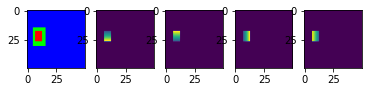

In [50]:
class MapOrdering:
    """порядок обведения слов"""
    SEG_WORD = 0
    SEG_SURROUNDING = 1
    SEG_BACKGROUND = 2
    GEO_TOP = 3
    GEO_BOTTOM = 4
    GEO_LEFT = 5
    GEO_RIGHT = 6
    NUM_MAPS = 7


def encode(shape, gt, f=1.0):
    gt_map = np.zeros((MapOrdering.NUM_MAPS,) + shape)
    for aabb in gt:
        aabb = aabb.scale(f, f)

        # segmentation map
        aabb_clip = AABB(0, shape[0] - 1, 0, shape[1] - 1)

        aabb_word = aabb.scale_around_center(0.5, 0.5).as_type(int).clip(aabb_clip)
        aabb_sur = aabb.as_type(int).clip(aabb_clip)
        gt_map[MapOrdering.SEG_SURROUNDING, aabb_sur.ymin:aabb_sur.ymax + 1, aabb_sur.xmin:aabb_sur.xmax + 1] = 1
        gt_map[MapOrdering.SEG_SURROUNDING, aabb_word.ymin:aabb_word.ymax + 1, aabb_word.xmin:aabb_word.xmax + 1] = 0
        gt_map[MapOrdering.SEG_WORD, aabb_word.ymin:aabb_word.ymax + 1, aabb_word.xmin:aabb_word.xmax + 1] = 1

        # geometry map TODO vectorize
        for x in range(aabb_word.xmin, aabb_word.xmax + 1):
            for y in range(aabb_word.ymin, aabb_word.ymax + 1):
                gt_map[MapOrdering.GEO_TOP, y, x] = y - aabb.ymin
                gt_map[MapOrdering.GEO_BOTTOM, y, x] = aabb.ymax - y
                gt_map[MapOrdering.GEO_LEFT, y, x] = x - aabb.xmin
                gt_map[MapOrdering.GEO_RIGHT, y, x] = aabb.xmax - x

    gt_map[MapOrdering.SEG_BACKGROUND] = np.clip(1 - gt_map[MapOrdering.SEG_WORD] - gt_map[MapOrdering.SEG_SURROUNDING],
                                                 0, 1)

    return gt_map


def subsample(idx, max_num):
    f = len(idx[0]) / max_num
    if f > 1:
        a = np.asarray([idx[0][int(j * f)] for j in range(max_num)], np.int64)
        b = np.asarray([idx[1][int(j * f)] for j in range(max_num)], np.int64)
        idx = (a, b)
    return idx


def fg_by_threshold(thres, max_num=None):
    def func(seg_map):
        idx = np.where(seg_map > thres)
        if max_num is not None:
            idx = subsample(idx, max_num)
        return idx

    return func


def fg_by_cc(thres, max_num):
    """take a maximum number of pixels per connected component, but at least 3 (->DBSCAN minPts)"""

    def func(seg_map):
        seg_mask = (seg_map > thres).astype(np.uint8)
        num_labels, label_img = cv2.connectedComponents(seg_mask, connectivity=4)
        max_num_per_cc = max(max_num // (num_labels + 1), 3)  # at least 3 because of DBSCAN clustering

        all_idx = [np.empty(0, np.int64), np.empty(0, np.int64)]
        for curr_label in range(1, num_labels):
            curr_idx = np.where(label_img == curr_label)
            curr_idx = subsample(curr_idx, max_num_per_cc)
            all_idx[0] = np.append(all_idx[0], curr_idx[0])
            all_idx[1] = np.append(all_idx[1], curr_idx[1])
        return tuple(all_idx)

    return func


def decode(pred_map, comp_fg=fg_by_threshold(0.5), f=1):
    idx = comp_fg(pred_map[MapOrdering.SEG_WORD])
    pred_map_masked = pred_map[..., idx[0], idx[1]]
    aabbs = []
    for yc, xc, pred in zip(idx[0], idx[1], pred_map_masked.T):
        t = pred[MapOrdering.GEO_TOP]
        b = pred[MapOrdering.GEO_BOTTOM]
        l = pred[MapOrdering.GEO_LEFT]
        r = pred[MapOrdering.GEO_RIGHT]
        aabb = AABB(xc - l, xc + r, yc - t, yc + b)
        aabbs.append(aabb.scale(f, f))
    return aabbs


def main():
    import matplotlib.pyplot as plt
    aabbs_in = [AABB(10, 30, 30, 60)]
    encoded = encode((50, 50), aabbs_in, f=0.5)
    aabbs_out = decode(encoded, f=2)
    print(aabbs_out[0])
    plt.subplot(151)
    plt.imshow(encoded[MapOrdering.SEG_WORD:MapOrdering.SEG_BACKGROUND + 1].transpose(1, 2, 0))

    plt.subplot(152)
    plt.imshow(encoded[MapOrdering.GEO_TOP])
    plt.subplot(153)
    plt.imshow(encoded[MapOrdering.GEO_BOTTOM])
    plt.subplot(154)
    plt.imshow(encoded[MapOrdering.GEO_LEFT])
    plt.subplot(155)
    plt.imshow(encoded[MapOrdering.GEO_RIGHT])

    plt.show()


if __name__ == '__main__':
    main()


# visualization.py

In [51]:
'''
визуализация
'''




def visualize(img, aabbs):
    img = ((img + 0.5) * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for aabb in aabbs:
        aabb = aabb.enlarge_to_int_grid().as_type(int)
        cv2.rectangle(img, (aabb.xmin, aabb.ymin), (aabb.xmax, aabb.ymax), (255, 0, 255), 2)

    return img

def visualize_and_plot(img, aabbs,delta):
    '''

    :param img:
    :param aabbs: список границ/выделений
    :param delta: отступ, в пикселях. увеличивает рамки вокруг слова на эту величину чтобы все буквы влезли целиком
    и ненароком не обрезать букву с длиным хвастом
    :return:
    '''
    plt.imshow(img, cmap='gray')
    for aabb in aabbs:
        start_point = (int(aabb.xmin-delta), int(aabb.ymin-delta))
        end_point = (int(aabb.xmax+delta), int(aabb.ymax+delta))
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0),1)
    return img








# dataset.py

In [52]:
# использовался для обучения
#
class DatasetIAM:

    def __init__(self, root_dir, input_size, output_size, caching=True):

        self.caching = caching
        self.input_size = input_size
        self.output_size = output_size
        self.loaded_img_scale = 0.25
        self.fn_gts = []
        self.fn_imgs = []
        self.img_cache = []
        self.gt_cache = []
        self.num_samples = 0

        fn_cache = root_dir / 'cache.pickle'
        if self.caching and fn_cache.exists():
            self.img_cache, self.gt_cache = pickle.load(open(fn_cache, 'rb'))
            self.num_samples = len(self.img_cache)
            return

        gt_dir = root_dir / 'gt'
        img_dir = root_dir / 'img'
        for fn_gt in sorted(gt_dir.files('*.xml')):
            fn_img = img_dir / fn_gt.stem + '.png'
            if not fn_img.exists():
                continue

            self.fn_imgs.append(fn_img.abspath())
            self.fn_gts.append(fn_gt.abspath())
            self.num_samples += 1

            if self.caching:
                img = cv2.imread(fn_img.abspath(), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, dsize=None, fx=self.loaded_img_scale, fy=self.loaded_img_scale)
                gt = self.parse_gt(fn_gt.abspath())

                img, gt = self.crop(img, gt)
                img, gt = self.adjust_size(img, gt)

                self.img_cache.append(img)
                self.gt_cache.append(gt)

        if self.caching:
            pickle.dump([self.img_cache, self.gt_cache], open(fn_cache, 'wb'))

    def parse_gt(self, fn_gt):
        tree = ET.parse(fn_gt)
        root = tree.getroot()

        aabbs = []  # list of all axis aligned bounding boxes of current sample

        # go over all lines
        for line in root.findall("./handwritten-part/line"):

            # go over all words
            for word in line.findall('./word'):
                xmin, xmax, ymin, ymax = float('inf'), 0, float('inf'), 0
                success = False

                # go over all characters
                for cmp in word.findall('./cmp'):
                    success = True
                    x = float(cmp.attrib['x'])
                    y = float(cmp.attrib['y'])
                    w = float(cmp.attrib['width'])
                    h = float(cmp.attrib['height'])

                    # aabb around all characters is aabb around word
                    xmin = min(xmin, x)
                    xmax = max(xmax, x + w)
                    ymin = min(ymin, y)
                    ymax = max(ymax, y + h)

                if success:
                    aabbs.append(AABB(xmin, xmax, ymin, ymax).scale(self.loaded_img_scale, self.loaded_img_scale))

        return aabbs

    def crop(self, img, gt):
        xmin = min([aabb.xmin for aabb in gt])
        xmax = max([aabb.xmax for aabb in gt])
        ymin = min([aabb.ymin for aabb in gt])
        ymax = max([aabb.ymax for aabb in gt])

        gt_crop = [aabb.translate(-xmin, -ymin) for aabb in gt]
        img_crop = img[int(ymin):int(ymax), int(xmin):int(xmax)]
        return img_crop, gt_crop

    def adjust_size(self, img, gt):
        h, w = img.shape
        fx = self.input_size[1] / w
        fy = self.input_size[0] / h
        gt = [aabb.scale(fx, fy) for aabb in gt]
        img = cv2.resize(img, dsize=self.input_size)
        return img, gt

    def __getitem__(self, idx):

        if self.caching:
            img = self.img_cache[idx]
            gt = self.gt_cache[idx]
        else:
            img = cv2.imread(self.fn_imgs[idx], cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, dsize=None, fx=self.loaded_img_scale, fy=self.loaded_img_scale)
            gt = self.parse_gt(self.fn_gts[idx])
            img, gt = self.crop(img, gt)
            img, gt = self.adjust_size(img, gt)

        return img, gt

    def __len__(self):
        return self.num_samples


class DatasetIAMSplit:
    """для разбиения датасета на трейн и тест"""
    def __init__(self, dataset, start_idx, end_idx):
        assert start_idx >= 0 and end_idx <= len(dataset)

        self.dataset = dataset
        self.start_idx = start_idx
        self.end_idx = end_idx

    def __getitem__(self, idx):
        return self.dataset[self.start_idx + idx]

    def __len__(self):
        return self.end_idx - self.start_idx


#if __name__ == '__main__':
    #from visualization import visualize
    #from coding import encode, decode
    #import matplotlib.pyplot as plt

    #dataset = DatasetIAM(Path('../data'), (350, 350), (350, 350), caching=False)
    #img, gt = dataset[0]
    #gt_map = encode(img.shape, gt)
    #gt = decode(gt_map)

    #plt.imshow(visualize(img / 255 - 0.5, gt))
    #plt.show()


# iou.py

In [53]:
import numpy as np


def compute_iou(ra, rb):
    """Вычисляет площадь пересечения границ слова которые предстазала сетка с границами которые были установлены при
    обучении площадь пересечения этих границ делит на площадь объединения.
    для одного слова это IOU"""
    if ra.xmax < rb.xmin or rb.xmax < ra.xmin or ra.ymax < rb.ymin or rb.ymax < ra.ymin:
        return 0

    l = max(ra.xmin, rb.xmin)
    r = min(ra.xmax, rb.xmax)
    t = max(ra.ymin, rb.ymin)
    b = min(ra.ymax, rb.ymax)

    intersection = (r - l) * (b - t)
    union = ra.area() + rb.area() - intersection

    iou = intersection / union
    return iou


def compute_dist_mat(aabbs):
    """Находим расстояние между всеми словами попарно"""
    num_aabbs = len(aabbs)

    dists = np.zeros((num_aabbs, num_aabbs))
    for i in range(num_aabbs):
        for j in range(num_aabbs):
            if j > i:
                break

            dists[i, j] = dists[j, i] = 1 - compute_iou(aabbs[i], aabbs[j])

    return dists


def compute_dist_mat_2(aabbs1, aabbs2):
    """Находим расстояние попарно между двумя списками слов"""
    num_aabbs1 = len(aabbs1)
    num_aabbs2 = len(aabbs2)

    dists = np.zeros((num_aabbs1, num_aabbs2))
    for i in range(num_aabbs1):
        for j in range(num_aabbs2):
            dists[i, j] = 1 - compute_iou(aabbs1[i], aabbs2[j])

    return dists


# loss.py

In [54]:
'''
Тут функция потерь нашей нейронной сети
'''



def compute_loss(y, gt_map):
    # 1. segmentation loss
    target_labels = torch.argmax(gt_map[:, MapOrdering.SEG_WORD:MapOrdering.SEG_BACKGROUND + 1], dim=1)
    loss_seg = F.cross_entropy(y[:, MapOrdering.SEG_WORD:MapOrdering.SEG_BACKGROUND + 1], target_labels)

    # 2. geometry loss
    # distances to all sides of aabb
    t = torch.minimum(y[:, MapOrdering.GEO_TOP], gt_map[:, MapOrdering.GEO_TOP])
    b = torch.minimum(y[:, MapOrdering.GEO_BOTTOM], gt_map[:, MapOrdering.GEO_BOTTOM])
    l = torch.minimum(y[:, MapOrdering.GEO_LEFT], gt_map[:, MapOrdering.GEO_LEFT])
    r = torch.minimum(y[:, MapOrdering.GEO_RIGHT], gt_map[:, MapOrdering.GEO_RIGHT])

    # area of predicted aabb
    y_width = y[:, MapOrdering.GEO_LEFT, ...] + y[:, MapOrdering.GEO_RIGHT, ...]
    y_height = y[:, MapOrdering.GEO_TOP, ...] + y[:, MapOrdering.GEO_BOTTOM, ...]
    area1 = y_width * y_height

    # area of gt aabb
    gt_width = gt_map[:, MapOrdering.GEO_LEFT, ...] + gt_map[:, MapOrdering.GEO_RIGHT, ...]
    gt_height = gt_map[:, MapOrdering.GEO_TOP, ...] + gt_map[:, MapOrdering.GEO_BOTTOM, ...]
    area2 = gt_width * gt_height

    # compute intersection over union
    intersection = (r + l) * (b + t)
    union = area1 + area2 - intersection
    eps = 0.01  # avoid division by 0
    iou = intersection / (union + eps)
    iou = iou[gt_map[:, MapOrdering.SEG_WORD] > 0]
    loss_aabb = -torch.log(torch.mean(iou))

    # total loss is simply the sum of both losses
    loss = loss_seg + loss_aabb
    return loss


# resnet.py

In [55]:
"""
используется нейронная сеть ResNet
взята из https://raw.githubusercontent.com/pytorch/vision/master/torchvision/models/resnet.py
по сути из хаба нейронных сетей pytorch. Удалил кое что что нам не нужно.
Этот файл нужен только для того чтобы вернуть нам архитектуру нейронной сети
"""




def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
            self,
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            num_classes: int = 1000,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        out1 = self.relu(x)
        x = self.maxpool(out1)

        out2 = self.layer1(x)
        out3 = self.layer2(out2)
        out4 = self.layer3(out3)
        out5 = self.layer4(out4)

        return out5, out4, out3, out2, out1

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
        arch: str,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        pretrained: bool,
        progress: bool,
        **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


# net.py

In [56]:




class UpscaleAndConcatLayer(torch.nn.Module):


    def __init__(self, cx, cy, cz):
        super(UpscaleAndConcatLayer, self).__init__()
        self.conv = torch.nn.Conv2d(cx + cy, cz, 3, padding=1)

    def forward(self, x, y, s):
        x = F.interpolate(x, s)
        z = torch.cat((x, y), 1)
        z = F.relu(self.conv(z))
        return z


class WordDetectorNet(torch.nn.Module):
    # fixed sizes for training
    input_size = (448, 448)
    output_size = (224, 224)
    scale_down = compute_scale_down(input_size, output_size)

    def __init__(self):
        super(WordDetectorNet, self).__init__()

        self.backbone = resnet18()

        self.up1 = UpscaleAndConcatLayer(512, 256, 256)  # input//16
        self.up2 = UpscaleAndConcatLayer(256, 128, 128)  # input//8
        self.up3 = UpscaleAndConcatLayer(128, 64, 64)  # input//4
        self.up4 = UpscaleAndConcatLayer(64, 64, 32)  # input//2

        self.conv1 = torch.nn.Conv2d(32, MapOrdering.NUM_MAPS, 3, 1, padding=1)

    @staticmethod
    def scale_shape(s, f):
        assert s[0] % f == 0 and s[1] % f == 0
        return s[0] // f, s[1] // f

    def output_activation(self, x, apply_softmax):
        if apply_softmax:
            seg = torch.softmax(x[:, MapOrdering.SEG_WORD:MapOrdering.SEG_BACKGROUND + 1], dim=1)
        else:
            seg = x[:, MapOrdering.SEG_WORD:MapOrdering.SEG_BACKGROUND + 1]
        geo = torch.sigmoid(x[:, MapOrdering.GEO_TOP:]) * self.input_size[0]
        y = torch.cat([seg, geo], dim=1)
        return y

    def forward(self, x, apply_softmax=False):
        # x: BxCxHxW
        # eval backbone with 448px: bb1: 224px, bb2: 112px, bb3: 56px, bb4: 28px, bb5: 14px
        s = x.shape[2:]
        bb5, bb4, bb3, bb2, bb1 = self.backbone(x)

        x = self.up1(bb5, bb4, self.scale_shape(s, 16))
        x = self.up2(x, bb3, self.scale_shape(s, 8))
        x = self.up3(x, bb2, self.scale_shape(s, 4))
        x = self.up4(x, bb1, self.scale_shape(s, 2))
        x = self.conv1(x)

        return self.output_activation(x, apply_softmax)


# eval.py

In [59]:
#использовался для тренировки и для переведения сетки из режима обучения в режим детекта
#под переводом режима подразумевается откючение алгоритма обратного распространения ошибки
#по сути для работы отсюда нужен только evaluate
#
#





EvaluateRes = namedtuple('EvaluateRes', 'batch_imgs,batch_aabbs,loss,metrics')


class BinaryClassificationMetrics:
    def __init__(self, tp, fp, fn):
        self.tp = tp
        self.fp = fp
        self.fn = fn

    def accumulate(self, other):
        tp = self.tp + other.tp
        fp = self.fp + other.fp
        fn = self.fn + other.fn
        return BinaryClassificationMetrics(tp, fp, fn)

    def recall(self):
        return self.tp / (self.tp + self.fp) if self.tp + self.fp > 0 else 0

    def precision(self):
        return self.tp / (self.tp + self.fn) if self.tp + self.fn > 0 else 0

    def f1(self):
        re = self.recall()
        pr = self.precision()
        return 2 * pr * re / (pr + re) if pr + re > 0 else 0


def binary_classification_metrics(gt_aabbs, pred_aabbs):
    iou_thres = 0.7

    ious = 1 - compute_dist_mat_2(gt_aabbs, pred_aabbs)
    match_counter = (ious > iou_thres).astype(np.int)
    gt_counter = np.sum(match_counter, axis=1)
    pred_counter = np.sum(match_counter, axis=0)

    tp = np.count_nonzero(pred_counter == 1)
    fp = np.count_nonzero(pred_counter == 0)
    fn = np.count_nonzero(gt_counter == 0)

    return BinaryClassificationMetrics(tp, fp, fn)


def evaluate(net, loader, thres=0.5, max_aabbs=None):
    batch_imgs = []
    batch_aabbs = []
    loss = 0

    for i in range(len(loader)):
        # get batch
        loader_item = loader[i]
        with torch.no_grad():
            y = net(loader_item.batch_imgs, apply_softmax=True)
            y_np = y.to('cpu').numpy()
            if loader_item.batch_gt_maps is not None:
                loss += compute_loss(y, loader_item.batch_gt_maps).to('cpu').numpy()

        scale_up = 1 / compute_scale_down(WordDetectorNet.input_size, WordDetectorNet.output_size)
        metrics = BinaryClassificationMetrics(0, 0, 0)
        for i in range(len(y_np)):
            img_np = loader_item.batch_imgs[i, 0].to('cpu').numpy()
            pred_map = y_np[i]

            aabbs = decode(pred_map, comp_fg=fg_by_cc(thres, max_aabbs), f=scale_up)
            h, w = img_np.shape
            aabbs = [aabb.clip(AABB(0, w - 1, 0, h - 1)) for aabb in aabbs]  # bounding box must be inside img
            clustered_aabbs = cluster_aabbs(aabbs)

            if loader_item.batch_aabbs is not None:
                curr_metrics = binary_classification_metrics(loader_item.batch_aabbs[i], clustered_aabbs)
                metrics = metrics.accumulate(curr_metrics)

            batch_imgs.append(img_np)
            batch_aabbs.append(clustered_aabbs)

    return EvaluateRes(batch_imgs, batch_aabbs, loss / len(loader), metrics)


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=10)
    parser.add_argument('--data_dir', type=Path, required=True)
    args = parser.parse_args()

    net = WordDetectorNet()
    net.load_state_dict(torch.load('../model/weights'))
    net.eval()
    net.to('cuda')

    dataset = DatasetIAM(args.data_dir, net.input_size, net.output_size, caching=False)
    dataset_eval = DatasetIAMSplit(dataset, 0, 10)
    loader = DataLoaderIAM(dataset_eval, args.batch_size, net.input_size, net.output_size)

    res = evaluate(net, loader, max_aabbs=1000)
    print(f'Loss: {res.loss}')
    print(f'Recall: {res.metrics.recall()}')
    print(f'Precision: {res.metrics.precision()}')
    print(f'F1 score: {res.metrics.f1()}')

    for img, aabbs in zip(res.batch_imgs, res.batch_aabbs):
        visualize_and_plot(img, aabbs)


#if __name__ == '__main__':
#    main()


# Infer.py

In [60]:
#соответствуенно запустить все что было до этого
#main - демонстрационный
#extract_words - как раз рабочий 
# надо только пути поменять



def main():
    parser = argparse.ArgumentParser()
    # поределяем на каком устройстве будет работать сеть cuda - видеокарта
    parser.add_argument('--device', choices=['cpu', 'cuda'], default='cpu')
    args = parser.parse_args()

    net = WordDetectorNet()  # получаем архитектуру нашей нейронной сети без весов
    #  загружаем веса нашей нейронной сети
    net.load_state_dict(torch.load('../model/weights', map_location=args.device))
    net.eval()  # переводим сеть в режим распознавания (вдруг она была в режиме обучения)
    #print(net)  # на случай если интересно посмотреть ее архитектуру
    net.to(args.device)  # отправляем нейронку на устройство которое выбрали

    #
    loader = DataLoaderImgFile(Path('../data/input'), net.input_size, args.device)
    res = evaluate(net, loader, max_aabbs=1000)
    print(res.batch_imgs)
    for i, (img, aabbs) in enumerate(zip(res.batch_imgs, res.batch_aabbs)):
        f = loader.get_scale_factor(i)
        aabbs = [aabb.scale(1 / f, 1 / f) for aabb in aabbs]
        img = loader.get_original_img(i)
        print(i)
        cv2.imshow('input', img)
        cv2.waitKey(0)
        img=visualize_and_plot(img, aabbs,5)
        cv2.imshow('input',img)
        cv2.waitKey(0)
        cv2.imwrite(f'./image-{i}.png', img*255)


#if __name__ == '__main__':
#    main()



def extract_words(input_path,output_path, delta):
    '''

    :param input_path: директория с изображениями для поиска
    :param output_path: директория с сохраненными словами
    :param delta: отступ от границ детекта в пикселях, сделано чтобы хваосты слов не обрезать
    :return:
    '''
    #проверяем папку с исходными изображениями
    if os.path.isdir(Path(input_path)):
        if len(Path(input_path).files('*.jpg'))== 0:
            print('Изображений для обработки не обнаружено. проверьте путь')
        else:
            print(f"Найдено {len(Path(input_path).files('*.jpg'))} изображений для обработки.")
    else:
        print(f'директория {input_path} не существует')
    #проверяем папку ку складываем
    if os.path.isdir(output_path):
        print(f'директория {output_path} уже существует')
    else:
        os.makedirs(output_path)
        print(f'директория {output_path} создана')

    #определяем устройство работы
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    #подгружаем нашу нейронную сеть
    net = WordDetectorNet()  # получаем архитектуру нашей нейронной сети без весов
    #  загружаем веса нашей нейронной сети
    net.load_state_dict(torch.load('../model/weights', map_location=device))
    net.eval()  # переводим сеть в режим распознавания (вдруг она была в режиме обучения)
    net.to(device)  # отправляем нейронку на устройство которое выбрали

    # создаем загрузчик изобраний
    loader = DataLoaderImgFile(Path(input_path), net.input_size, device)
    res = evaluate(net, loader, max_aabbs=1000)  #max_aabbs максимальное число слов на листе. более чем достаточно
    #приступаем к работе !!!!!!!!!!!!!
    # цикл по изображениям и спискам детектов на каждом
    for i, (img, aabbs) in enumerate(zip(res.batch_imgs, res.batch_aabbs)):
        f = loader.get_scale_factor(i) # определяем направление изображения
        aabbs = [aabb.scale(1 / f, 1 / f) for aabb in aabbs] # применяем это к рамкам
        img , img_name = loader.get_original_img_with_name(i) # получаем оригинальное изобра и его имя
        img_name = img_name.split('/')[-1] # выделяем только нахвание
        img2 = visualize_and_plot(img, aabbs, 5) # покеазываем как выделили слова
        cv2.imshow('detected words', img2)
        cv2.waitKey(0)
        index=0
        for aabb in aabbs: # вырезаем каждое найденное слово/символ и сохраняем
            word = img[int(aabb.ymin - delta):int(aabb.ymax + delta), int(aabb.xmin - delta):int(aabb.xmax + delta)]
            file_name = output_path+'/' + img_name.split('.')[0] + '_' + str(index) + '.' + img_name.split('.')[1]
            try:
                cv2.imwrite(file_name,word*255)
            except:
                print('error with image writing')
            index+=1


extract_words('../data/input', '../data/output', 5)

директория ../data/input не существует
директория ../data/output создана
Using device: cpu


FileNotFoundError: [Errno 2] No such file or directory: '../model/weights'